In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import ViTConfig, ViTModel

from src.datasets import CustomDataset, unet_inference
from src.unetr_2x2 import CustomUNETR2
from src.utils import select_device

Load Data

In [2]:
device = select_device()

data = np.load("/home/mhill/Projects/cathepsin/data/inference_data.dat.npy")  # shape: (12065, 16, 64, 64)

dataset = CustomDataset(data)

test_dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=unet_inference
)

Model Config 

In [3]:
# Load specific model config 
vitconfig = {
    "attention_probs_dropout_prob": 0.0,
    "encoder_stride": 2,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "hidden_size": 192,
    "image_size": 64,
    "initializer_range": 0.02,
    "intermediate_size": 768,
    "layer_norm_eps": 1e-06,
    "model_type": "vit",
    "num_attention_heads": 6,
    "num_channels": 16,
    "num_hidden_layers": 6,
    "patch_size": 2,
    "qkv_bias": True,
    "transformers_version": "4.42.3"
}

unet_config = {  # can retrieve from log/info.md
    'BATCH_SIZE': 32,
    'BETA_1': 0.9,
    'BETA_2': 0.95,
    'COMMENT': 'Run 21: Patch 02 w/augmented data 150 epochs, 128 feature size',
    'FEATURE_SIZE': 128,
    'IN_CHANNEL': 16,
    'LEARNING_RATE': 1e-05,
    'LOG_DIR': 'logs/unetr/21/',
    'NUM_CLASSES': 16,
    'NUM_EPOCHS': 150,
    'PRE_TRAINED_MODEL': '/home/mhill/Projects/cathepsin/logs/vitmae/12/model.pth',
    'RANDOM_SEED': 42,
    'RES_BLOCK': True,
    'SAVE_MODELS': 1,
    'SPATIAL_DIMS': 2,
    'TEST_DATASET': '/home/mhill/Projects/cathepsin/data/unet_testing_dataset.npz',
    'TRAIN_DATASET': '/home/mhill/Projects/cathepsin/data/unet_training_dataset.npz',
    'VALID_DATASET': '/home/mhill/Projects/cathepsin/data/unet_validation_dataset.npz',
    'WEIGHT_DECAY': 0.0
}

MODEL_PATH = "/home/mhill/Projects/cathepsin/logs/unetr/21/model.pth"  # <-- set model path 
checkpoint = torch.load(MODEL_PATH, map_location=device)

encoder = ViTModel(config=ViTConfig(**vitconfig))

model = CustomUNETR2(encoder=encoder, feature_size=unet_config["FEATURE_SIZE"],
                     num_classes=unet_config["NUM_CLASSES"]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:

model.eval()
images = []
all_predictions = []

with torch.inference_mode():
    for i, image in enumerate(test_dataloader):
        image = image.to(device).float()
        outputs = model(image)
        predictions = torch.argmax(outputs, dim=1)

        images_np = image.cpu().numpy()
        predictions_np = predictions.cpu().numpy()

        images.append(images_np)
        all_predictions.append(predictions_np)
x = np.concatenate(images, axis=0)
y = np.concatenate(all_predictions, axis=0)  # (12065, 64, 64)



In [11]:
import matplotlib.pyplot as plt

# colors = np.array([
#     [0x00,0x00,0x00], [0x00,0x00,0xff], [0x00,0xff,0x00], [0x00,0xff,0xff],
#     [0xff,0x00,0xff], [0xff,0xff,0x00], [0xff,0x00,0x00], [0xa0,0xa0,0xa4],
#     [0x80,0x00,0x00], [0x00,0x80,0x00], [0x00,0x00,0x80], [0x00,0x80,0x80],
#     [0x80,0x00,0x80], [0x80,0x80,0x00], [0x80,0x80,0x80], [0xff,0xff,0xff]], np.uint8)

colors = np.array([
    [217, 217, 217], [168, 185, 205], [250, 250, 250], [166, 159, 154],
    [0, 0, 0], [208, 193, 188], [90, 84, 97], [0, 0, 0],
    [193, 176, 180], [145, 175, 201], [0, 0, 0], [139, 120, 191],
    [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], np.uint8)

labels = {
    0: "background",
    1: "white blood cell",
    2: "platelet",
    3: "outer rbc",
    4: "reticulocyte (missing)",
    5: "inner rbc",
    6: "beads",
    7: "monster bead",
    8: "sensor scratch",
    9: "chambertop scratch",
    10: "debris",
    11: "bubble",
}


def apply_color_map(label_image, color_map):
    colored_image = np.zeros((label_image.shape[0], label_image.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(color_map):
        colored_image[label_image == label] = color
    return colored_image


sr = x[:, :12, 16:-16, 16:-16].reshape(3072 // 32 - 1, 4096 // 32 - 1, 2, 2, 3, 32, 32)
sr = sr.transpose(0, 5, 2, 1, 6, 3, 4).reshape((3072 - 32) * 2, (4096 - 32) * 2, 3)

z = y[:, 16:-16, 16:-16].reshape(3072 // 32 - 1, 4096 // 32 - 1, 32, 32)
z = z.transpose(0, 2, 1, 3).reshape(3072 - 32, 4096 - 32)

colored_z = apply_color_map(z, colors)

plt.figure();
plt.imsave("/home/mhill/Projects/BloodSeg-UNETR/out_images/input2.png", sr)
plt.figure();
plt.imsave("/home/mhill/Projects/BloodSeg-UNETR/out_images/output4.png", colored_z)  #could also imshow(z, cmap='jet')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Below to check a single photo

6012


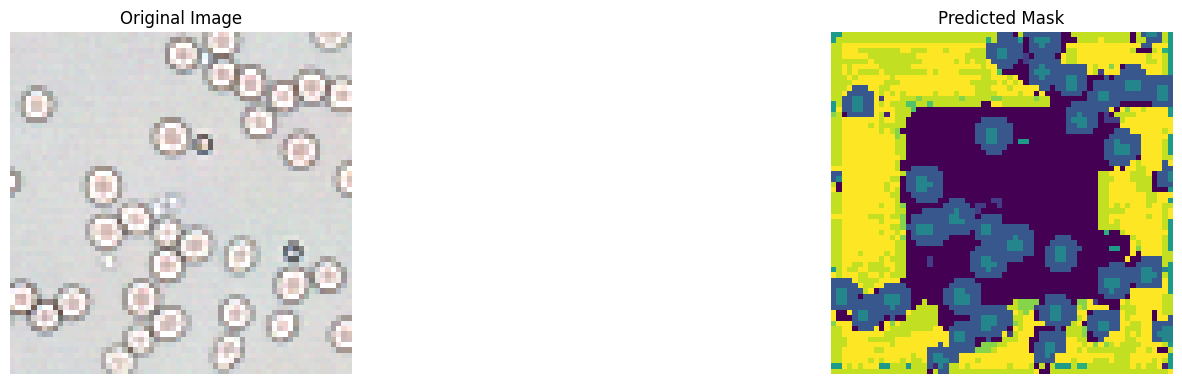

In [ ]:
from src.plotters import visualize_inference

mid = len(data) // 2

image = data[mid - 20:mid][:][:][:]
print(mid - 20)

test_dataloader = DataLoader(
    dataset=image,
    batch_size=1,
    shuffle=False,
    collate_fn=unet_inference

)

device = select_device()
model.eval()
with torch.inference_mode():
    img = next(iter(test_dataloader))
    img = img.to(device)
    outputs = model(img)
    predictions = torch.argmax(outputs, dim=1)

    # Convert to numpy arrays for visualization
    image_np = img.cpu().numpy()
    predictions_np = predictions.cpu().numpy()
    # Visualize the predictions
    visualize_inference(1, images=image_np, predictions=predictions_np, labels=None)

In [ ]:
# np.save("/home/mhill/Projects/cathepsin/predicition_np", predictions_np)